To begin with let us define, visualize, and sample from each metastable basin of the double well potential in 2D as defined by 
$$
E(x,y) = \frac{1}{4} ax^4 - \frac{1}{2}bx^2 +cx+\frac{1}{2}dy^2.
$$

Thus, the potential is harmonic in y-direction and bistable in x-direction. We will use $a=b=d=1$ and $b=6$ based on the paper.

In [9]:
def make_double_well_potential(a=1, b=6, c=1, d=1):
    def f(X): # supports either input of format (x,y) or X
        x, y = X[...,0], X[...,1]
        return 1/4*a*x**4 - 1/2*b*x**2 + c*x + 1/2*d*y**2
    return f

f = make_double_well_potential()

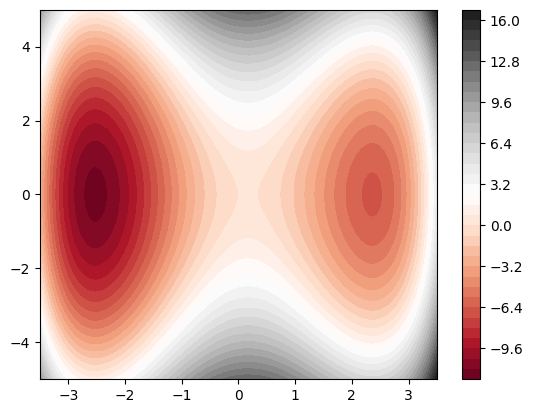

In [10]:
# Contour plot code snippet from https://jakevdp.github.io/PythonDataScienceHandbook/04.04-density-and-contour-plots.html
import matplotlib.pyplot as plt
import numpy as np

xmin, xmax = -3.5, 3.5
ymin, ymax = -5, 5
nx, ny = 100, 100

x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)

X, Y = np.meshgrid(x, y)
E = f(np.concatenate([X[..., None], Y[..., None]], axis=-1))

plt.contourf(X, Y, E, 40, cmap='RdGy') 
plt.colorbar();

Text(0, 0.5, '$U(x_1, x_2)$')

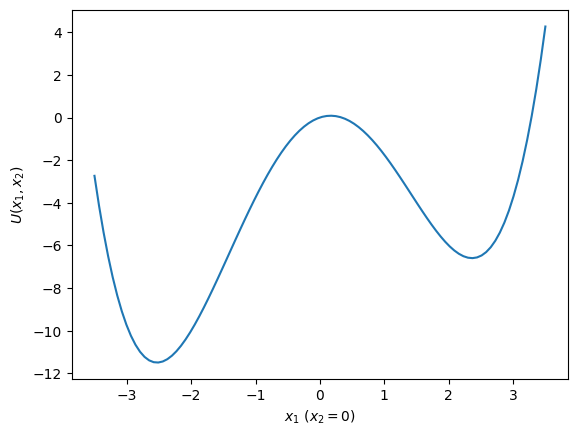

In [14]:
x = np.linspace(xmin, xmax, nx)
y = np.zeros_like(x)
energy = f(np.concatenate([x[..., None], y[..., None]], axis=1))
plt.plot(x, energy)
plt.xlabel("$x_1 \ (x_2=0)$")
plt.ylabel("$U(x_1, x_2)$")

Note Figure 2a seems slightly wrong as the $x_1$ coordinate of the left minima should be less than -2 using the parameters provided in the SI section. It's just a minor problem for us.

We can also make a plot of unnormalized marginal density of the Boltzmann distribution along the $x_1$ axis using Monte Carlo sampling over a grid since the double well model in two dimensions is still easy to compute this way.

Text(0, 0.5, 'Unnormalized density')

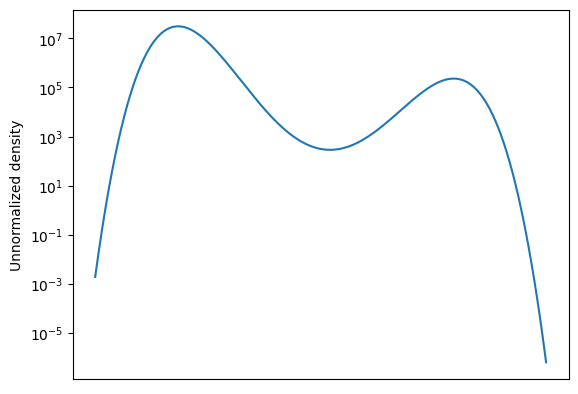

In [19]:
def density_profile(xmin=-4, xmax=4, N=1000, T=1, Efun=f, sum_dim=1):
    grid = np.mgrid[xmin:xmax:N*1j, xmin:xmax:N*1j]
    energy = Efun(grid.transpose(1,2,0))
    proba = np.exp(-1/T*energy)
    marginal = np.sum(proba, axis=sum_dim)
    return marginal

profile = density_profile(T=1)
plt.semilogy(profile)
plt.xticks([])
plt.ylabel("Unnormalized density")

Per the description from the methods section, the "MD simulations" are emulated by Metropolis Monte Carlo with steps drawn from an isotropic Gaussian. This is easy to code. We will generate two trajectories in each basin.

In [20]:
N = 10_000
T = 1.0
sigma = 0.1
min_l = np.array([-2.5, 0])
saddle = np.array([0, 0])
min_r = np.array([2.3, 0])


def generate_traj(init, N, Efun=f, seed=1) -> np.ndarray:
    np.random.seed(seed)
    pts = [init]
    while N > 1:
        next_pt = pts[-1] + np.random.normal(0, sigma, size=(2))
        E_last = Efun(pts[-1])
        E_curr = Efun(next_pt)
        if np.random.uniform() <= min(1, np.exp(-1/T*(E_curr-E_last))): # kb=1
            pts.append(next_pt)
            N-=1
    return np.column_stack(pts)

traj_l = generate_traj(min_l, N)
traj_m = generate_traj(saddle, N)
traj_r = generate_traj(min_r, N)

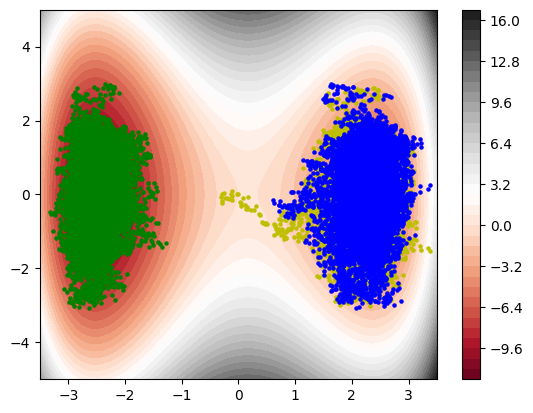

In [21]:
plt.contourf(X, Y, E, 40, cmap='RdGy') 
plt.colorbar();
plt.scatter(traj_l[0,:], traj_l[1,:], s=5, c='g')
plt.scatter(traj_m[0,:], traj_m[1,:], s=5, c='y')
plt.scatter(traj_r[0,:], traj_l[1,:], s=5, c='b')


We see that as expected, our sampling got stuck in each basin and if we start from the saddle point, it will slid into one of the basins (not necessarily the global minimum!) and got stuck there for a while. Now we have the artificial data we will use these to fit the BG model using both forward (sample-based) and reverse KL divergence (energy-based).

First we copy over the definitions.

In [22]:
import jax
import jax.numpy as jnp
import haiku as hk
from jax.config import config
config.update("jax_enable_x64", True) # is this necessary? Test later

from models.RealNVP import RealNVPStack # please see the model definition 

In [25]:
# transpose so we can take batch of samples with the first dimension
traj_l = traj_l.T
traj_r = traj_r.T

In [17]:
# rng_key = jax.random.PRNGKey(41)
# batch_size, n_hidden, n_channels, n_layers = 100, 4, 1, 4
# RealNVP_stack_forward = hk.without_apply_rng(hk.transform(lambda z1, z2: RealNVPStack(n_channels, n_layers, n_hidden).forward(z1, z2)))
# RealNVP_stack_reverse = hk.without_apply_rng(hk.transform(lambda x1, x2: RealNVPStack(n_channels, n_layers, n_hidden).reverse(x1, x2)))
# z1, z2 = jnp.ones([batch_size, n_channels]), jnp.ones([batch_size, n_channels])
# params = RealNVP_stack_forward.init(rng_key, z1, z2)

In [40]:
from importlib import reload # python 2.7 does not require this
import models.RealNVP_distrax
reload( models.RealNVP_distrax )
from models.RealNVP_distrax import make_forward_reverse_flow_models, make_KL_loss_funs, \
                                   make_base_dist, make_nway_affine_coupling_flow

base_dist = make_base_dist(event_shape=[2])
forward_model, reverse_model = make_forward_reverse_flow_models(make_flow_model=make_nway_affine_coupling_flow, 
                                                                event_shape=[2])
forward_KL, reverse_KL, combined_KL = make_KL_loss_funs(forward_model, reverse_model, 
                                                        energy_fun=f, base_dist=base_dist)

In [19]:
# import optax

# # Again, these are Monte Carlo estimators and we train with SGD (what if we use entire dataset? 1,000 is doable)
# def forward_KL(params, batch): # x.shape = n_batch, 2 * n_channels
#     loss = 0
#     x1, x2 = batch[:, :n_channels], batch[:, n_channels:]
#     z1, z2, ldj = RealNVP_stack_reverse.apply(params, x1, x2)
#     loss += -jnp.sum(optax.l2_loss(z1))
#     loss += -jnp.sum(optax.l2_loss(z2))
#     loss += jnp.sum(ldj)
#     return -loss / batch_size

# def reverse_KL(params, batch):
#     loss = 0
#     z1, z2 = batch[:, :n_channels], batch[:, n_channels:]
#     x1, x2, ldj = RealNVP_stack_forward.apply(params, z1, z2)
#     loss += jnp.sum(ldj)
#     loss += 1/T * jnp.sum(f(x1, x2))
#     return -loss / batch_size

# def combined_KL(params, x_batch, z_batch):
#     loss = 0.2*forward_KL(params, x_batch) + 0.8*reverse_KL(params, z_batch)

In [27]:
# hstack and then reshape interleaves rows of traj_l and traj_r
batch_size, n_hidden, n_channels, n_layers = 1000, 4, 1, 4

# training_data = jnp.reshape(jnp.hstack((traj_l, traj_r)).reshape(2*N, 2), (20, batch_size, 2*n_channels))
training_data = traj_l.reshape(10, batch_size, 2*n_channels)
training_data.shape

(10, 1000, 2)

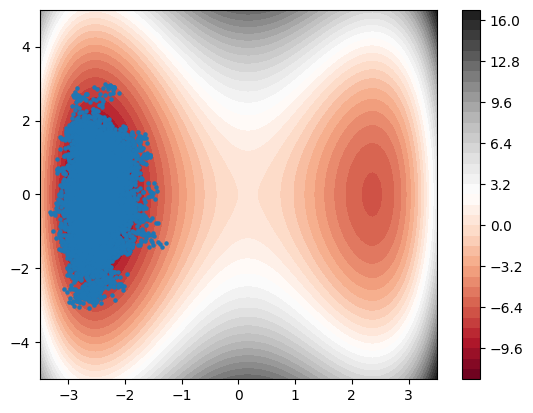

In [28]:
plt.contourf(X, Y, E, 40, cmap='RdGy') 
plt.colorbar();
plt.scatter(training_data[:,:,0], training_data[:,:,1], s=5)

In [29]:
import optax

def fit(params, optimizer, epochs, training_data) -> optax.Params:
    opt_state = optimizer.init(params)
    
    @jax.jit
    def step(params, opt_state, batch):
        loss_value, grads = jax.value_and_grad(forward_KL)(params, batch)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    for epoch in range(epochs):
        for i, batch in enumerate(training_data):
            params, opt_state, loss_value = step(params, opt_state, batch)
        print(f'Epoch {epoch}, loss: {loss_value}')
    return params

def more_fit(params, optimizer, epochs, training_data, random_data) -> optax.Params:
    opt_state = optimizer.init(params)
    
    @jax.jit
    def step(params, opt_state, batch):
        x_batch, z_batch = batch
        loss_value, grads = jax.value_and_grad(combined_KL)(params, x_batch, z_batch)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    for epoch in range(epochs):
        for i, batch in enumerate(zip(training_data, random_data)):
            params, opt_state, loss_value = step(params, opt_state, batch)
        print(f'Epoch {epoch}, loss: {loss_value}')
    return params

In [17]:
rng_key = jax.random.PRNGKey(41)
params = reverse_model.init(rng_key, batch=jnp.ones([batch_size, 2]))

In [65]:
optimizer = optax.adam(learning_rate=1e-3)
params = fit(params, optimizer, 50, training_data)

Epoch 0, loss: 3.193500100585427
Epoch 1, loss: 2.642222529044829
Epoch 2, loss: 2.587187484092265
Epoch 3, loss: 2.589831667546563
Epoch 4, loss: 2.525258140261307
Epoch 5, loss: 2.419488964014105
Epoch 6, loss: 2.3219937139700257
Epoch 7, loss: 2.2220338071559027
Epoch 8, loss: 2.1156623736633664
Epoch 9, loss: 2.004244525644184
Epoch 10, loss: 1.8912895295617822
Epoch 11, loss: 1.779034067402325
Epoch 12, loss: 1.6676117677460132
Epoch 13, loss: 1.5550909653201936
Epoch 14, loss: 1.4421639901527474
Epoch 15, loss: 1.330322257637114
Epoch 16, loss: 1.2186465391440793
Epoch 17, loss: 1.1066766593432011
Epoch 18, loss: 0.9948872026447021
Epoch 19, loss: 0.8837659445484415
Epoch 20, loss: 0.7722373043598582
Epoch 21, loss: 0.660833469459718
Epoch 22, loss: 0.5500129577679805
Epoch 23, loss: 0.43851704039365885
Epoch 24, loss: 0.32888568372439203
Epoch 25, loss: 0.21931897371570572
Epoch 26, loss: 0.11080098119112579
Epoch 27, loss: 0.0037849966213445185
Epoch 28, loss: -0.10158182645791

In [33]:
def plot_latent_space(forward_model, params, sigma=1.):
    z_new = jax.random.normal(rng_key, shape=(1000, 2))*sigma
    x_new, _ = forward_model.apply(params, z_new)
    plt.contourf(X, Y, E, 40, cmap='RdGy') 
    plt.colorbar(cmap='RdGy')
    plt.scatter(x_new[:,0], x_new[:,1], s=5)


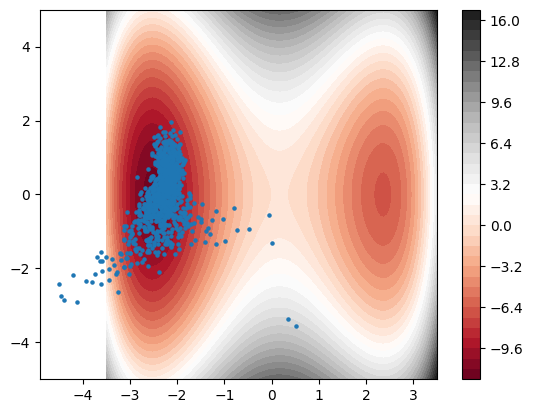

In [54]:
plot_latent_space(forward_model, params)

In [18]:
import distrax
from typing import Callable

def generate_traj_from_latent(init, flow: Callable, 
                              sigma=0.1, T=1,
                              N=1_000, Efun=f, seed=1) -> np.ndarray:
    np.random.seed(seed)
    last_pt = init
    pts = [flow(init)]
    while N > 1:
        next_pt = pts[-1] + np.random.normal(0, sigma, size=(2))
        pt_last = flow(last_pt)
        pt_curr = flow(next_pt)
        E_last = Efun(pt_last[0], pt_last[1])[0]
        E_curr = Efun(pt_curr[0], pt_curr[1])[0]
        print(E_last, E_curr)
        if np.random.uniform() <= min(1, np.exp(-1/T*(E_curr-E_last))): # kb=1
            pts.append(flow(next_pt))
            last_pt = next_pt
            N-=1
    return np.column_stack(pts)

In [31]:
def adaptive_fit(params, optimizer, epochs, training_data, rng_key, efun=f, 
                 sigma_range=[0.1, 1], 
                 log_beta_range=[-3, 0]):
    opt_state = optimizer.init(params)
    
    @jax.jit
    def step(params, opt_state, batch, beta, sigma, rng_key):
        x_batch, rand_z_batch = batch
        rng_key, *subkeys = jax.random.split(rng_key, 3)
        z_batch, log_proba_xz = reverse_model.apply(params, x_batch)
        z_batch_new = z_batch + jax.random.normal(key=subkeys[0], shape=x_batch.shape) * sigma
        x_batch_new, log_proba_new_zx = forward_model.apply(params, z_batch_new)
        
        delta_E = efun(x_batch_new) - efun(x_batch)
        delta_log_zx_proba = log_proba_new_zx + log_proba_xz
        
        # update entire batch
        mask = jax.random.uniform(key=subkeys[1]) <= jnp.minimum(1, jnp.exp(-beta*delta_E + delta_log_zx_proba)) # kb=1
        mask = mask[:, None] # prepares for broadcast
        x_batch_updated = mask * x_batch_new + (1-mask) * x_batch
            
        loss_value, grads = jax.value_and_grad(combined_KL)(params, x_batch, rand_z_batch, beta)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value, x_batch_updated, rng_key

    @jax.jit
    def get_random_data(rng_key):
        random_data = jax.random.normal(subkey, shape=training_data.shape)
        return random_data
    
    for epoch, sigma, beta in zip(range(epochs),
                                  jnp.linspace(sigma_range[0], sigma_range[1], epochs),
                                  jnp.logspace(log_beta_range[0], log_beta_range[1], epochs)):
        rng_key, subkey = jax.random.split(rng_key, 2)
        random_data = get_random_data(subkey)
        for i, batch in enumerate(zip(training_data, random_data)):
            params, opt_state, loss_value, x_batch_updated, rng_key = step(params, opt_state, batch, beta, sigma, rng_key)
            training_data = training_data.at[i].set(x_batch_updated)
        
        print(f'Epoch {epoch}, loss: {loss_value}')
        
        if epoch % 50 == 0:
            plot_latent_space(forward_model, params, sigma=1)
            plt.show()
        
    return params, training_data

In [34]:
# for the second phase we sample directly from the latent space
more_traj = generate_traj_from_latent(saddle[None, :], flow=lambda x: forward_model.apply(params, x)[0], 
                                      sigma=1, T=1000, N=1_000)
more_training_data = more_traj.reshape(10, batch_size, 2*n_channels)

params = more_fit(params, optimizer, 450, more_training_data, random_data)

NameError: name 'generate_traj_from_latent' is not defined

Note after the first few epochs of using forward KL divergence, i.e., making the modelled distribution similar to the reference distribution, we model the basins covered by the two trajectories well, but the interpolated path in the middle is not exactly the lowest energy path. We may simulate more, (which is mentioned in the SI section of the paper) using reverse KL divergence that evaluates energy of generated states to fix the problem.

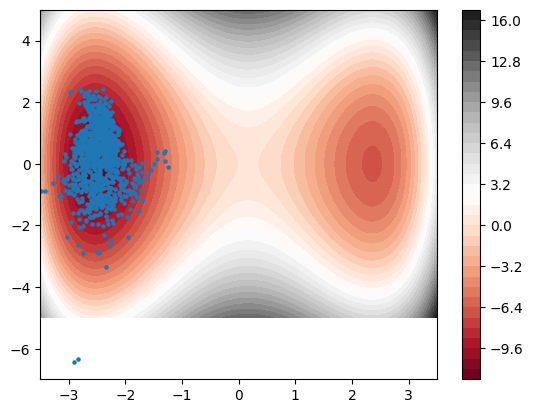

In [68]:
plot_latent_space(forward_model, params)

Finally, we will check the result of the adaptive sampling during training protocol proposed in the Boltzmann paper:

Epoch 0, loss: 0.8380722515946717


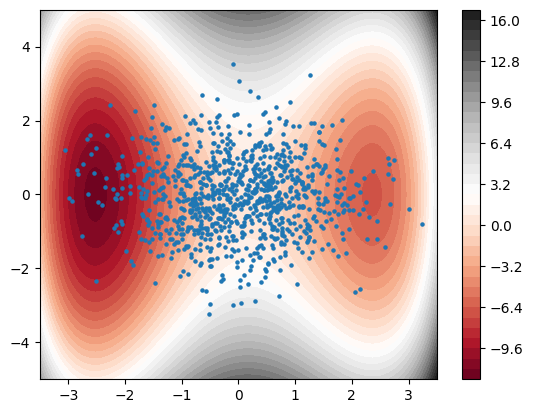

Epoch 1, loss: 0.715620578890679
Epoch 2, loss: 0.6013597170214232
Epoch 3, loss: 0.48827683904265584
Epoch 4, loss: 0.3516702496808531
Epoch 5, loss: 0.18716534962926387
Epoch 6, loss: 0.011505710395922344
Epoch 7, loss: -0.13702129695926965
Epoch 8, loss: -0.2081564833551801
Epoch 9, loss: -0.22109682017706273
Epoch 10, loss: -0.25844001019041396
Epoch 11, loss: -0.28285974045393786
Epoch 12, loss: -0.27058502940784185
Epoch 13, loss: -0.29591923593861974
Epoch 14, loss: -0.3114655484349753
Epoch 15, loss: -0.3120202838695655
Epoch 16, loss: -0.29895457469293574
Epoch 17, loss: -0.3114926270663874
Epoch 18, loss: -0.3069066425551081
Epoch 19, loss: -0.32130791198566805
Epoch 20, loss: -0.3331290141840486
Epoch 21, loss: -0.34393158410225383
Epoch 22, loss: -0.3558899986932763
Epoch 23, loss: -0.33241992591325353
Epoch 24, loss: -0.3512163909206557
Epoch 25, loss: -0.32107579008852905
Epoch 26, loss: -0.34369683189953576
Epoch 27, loss: -0.3623727041313968
Epoch 28, loss: -0.370725539

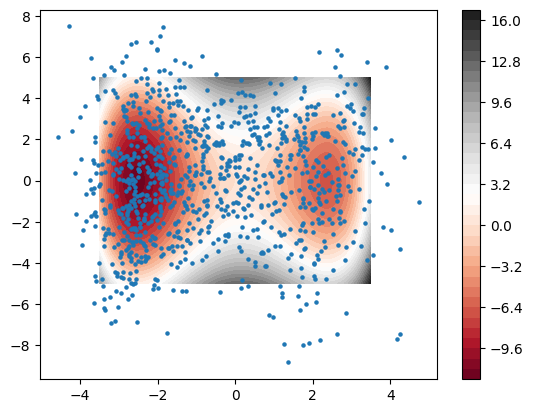

Epoch 51, loss: -0.4455804296205079
Epoch 52, loss: -0.4671377751942139
Epoch 53, loss: -0.4775923631586601
Epoch 54, loss: -0.49336308498502407
Epoch 55, loss: -0.5271090557899164
Epoch 56, loss: -0.5442000619186926
Epoch 57, loss: -0.5694525436037292
Epoch 58, loss: -0.5846776904378553
Epoch 59, loss: -0.5738916114268294
Epoch 60, loss: -0.5914982707119544
Epoch 61, loss: -0.5649200401799538
Epoch 62, loss: -0.5413043533175258
Epoch 63, loss: -0.5679922530457749
Epoch 64, loss: -0.5265718950122813
Epoch 65, loss: -0.5188811268797602
Epoch 66, loss: -0.5481766471163105
Epoch 67, loss: -0.5459572675587537
Epoch 68, loss: -0.514193130649265
Epoch 69, loss: -0.5449494582468045
Epoch 70, loss: -0.5254126590193385
Epoch 71, loss: -0.5580825546870787
Epoch 72, loss: -0.5814595639048117
Epoch 73, loss: -0.5935024893416943
Epoch 74, loss: -0.593158685600557
Epoch 75, loss: -0.6076884255160855
Epoch 76, loss: -0.6330660110069184
Epoch 77, loss: -0.6174856198954819
Epoch 78, loss: -0.6461161756

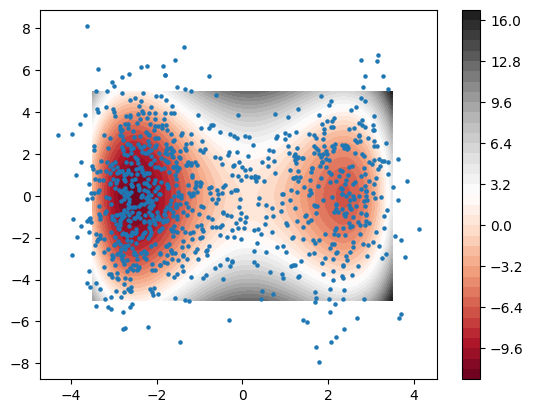

Epoch 101, loss: -0.6189616821062651
Epoch 102, loss: -0.5787065229888599
Epoch 103, loss: -0.6120600081279197
Epoch 104, loss: -0.6480530284894425
Epoch 105, loss: -0.6616722814096845
Epoch 106, loss: -0.6925665533146672
Epoch 107, loss: -0.7176957311578026
Epoch 108, loss: -0.7462948000927415
Epoch 109, loss: -0.749432246800499
Epoch 110, loss: -0.7175329186295569
Epoch 111, loss: -0.679929332024985
Epoch 112, loss: -0.7158185611963692
Epoch 113, loss: -0.732905504389225
Epoch 114, loss: -0.7604847329464852
Epoch 115, loss: -0.7868995261193794
Epoch 116, loss: -0.764443914877267
Epoch 117, loss: -0.7837080224681089
Epoch 118, loss: -0.7753261037192555
Epoch 119, loss: -0.7645741087271581
Epoch 120, loss: -0.793168460261625
Epoch 121, loss: -0.8107999706344058
Epoch 122, loss: -0.8258443159360603
Epoch 123, loss: -0.823284469611396
Epoch 124, loss: -0.7891045430204198
Epoch 125, loss: -0.800080788217182
Epoch 126, loss: -0.8032466297528336
Epoch 127, loss: -0.8249441594825629
Epoch 12

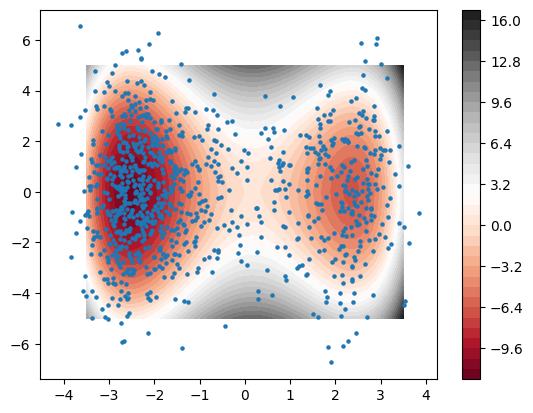

Epoch 151, loss: -0.9282316960863759
Epoch 152, loss: -0.9236449486876408
Epoch 153, loss: -0.9412752789850283
Epoch 154, loss: -0.9663417638164987
Epoch 155, loss: -0.9865347162060246
Epoch 156, loss: -0.9765338996142081
Epoch 157, loss: -0.998753074895469
Epoch 158, loss: -0.9724661832320799
Epoch 159, loss: -0.988874202923665
Epoch 160, loss: -0.9580033260558849
Epoch 161, loss: -0.987117097027116
Epoch 162, loss: -0.9653231353312057
Epoch 163, loss: -0.9374976699752442
Epoch 164, loss: -0.954116524295744
Epoch 165, loss: -0.9768643582993017
Epoch 166, loss: -0.9105063559466233
Epoch 167, loss: -0.9489053782040467
Epoch 168, loss: -0.9464090478893048
Epoch 169, loss: -0.9389391610970398
Epoch 170, loss: -0.8730926348547481
Epoch 171, loss: -0.8918053156930779
Epoch 172, loss: -0.8674045964217587
Epoch 173, loss: -0.8338797817495787
Epoch 174, loss: -0.8232308849548604
Epoch 175, loss: -0.8580056906930714
Epoch 176, loss: -0.8770416586321348
Epoch 177, loss: -0.8951268282959718
Epoch

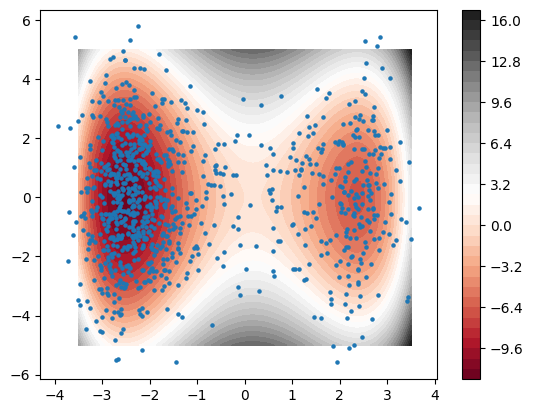

Epoch 201, loss: -1.1204212809613183
Epoch 202, loss: -1.1016110492984896
Epoch 203, loss: -1.1467678348394454
Epoch 204, loss: -1.1746178792662603
Epoch 205, loss: -1.210503938883071
Epoch 206, loss: -1.2258154223829838
Epoch 207, loss: -1.2236494252473356
Epoch 208, loss: -1.2441697097181559
Epoch 209, loss: -1.2324151032865025
Epoch 210, loss: -1.2315125539483573
Epoch 211, loss: -1.2687778387199762
Epoch 212, loss: -1.2827864549595491
Epoch 213, loss: -1.2210856693139638
Epoch 214, loss: -1.2544248488240368
Epoch 215, loss: -1.2330515538064495
Epoch 216, loss: -1.228158493554517
Epoch 217, loss: -1.2280392205025472
Epoch 218, loss: -1.2340318132952097
Epoch 219, loss: -1.2413080968877073
Epoch 220, loss: -1.28772535151524
Epoch 221, loss: -1.2981920755836953
Epoch 222, loss: -1.3305316661821618
Epoch 223, loss: -1.356999481005687
Epoch 224, loss: -1.3659693948997893
Epoch 225, loss: -1.3837507803147753
Epoch 226, loss: -1.3914586374982143
Epoch 227, loss: -1.3986000983139448
Epoch 

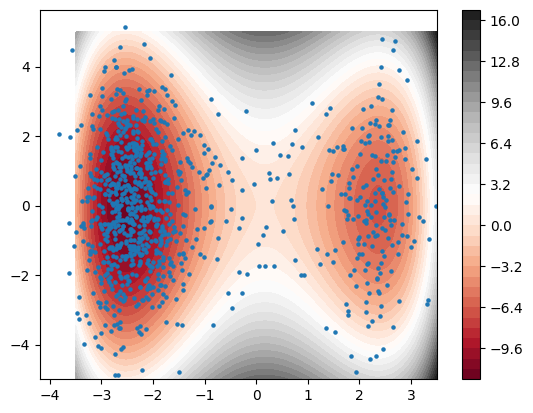

Epoch 251, loss: -1.463986674352811
Epoch 252, loss: -1.4883563721269926
Epoch 253, loss: -1.545198799333297
Epoch 254, loss: -1.5605430092421408
Epoch 255, loss: -1.610824440540421
Epoch 256, loss: -1.6560469601334125
Epoch 257, loss: -1.690124176566272
Epoch 258, loss: -1.7052474638649617
Epoch 259, loss: -1.7370238413133232
Epoch 260, loss: -1.7347251071352738
Epoch 261, loss: -1.7691633174887686
Epoch 262, loss: -1.7839209227373662
Epoch 263, loss: -1.8141761901301028
Epoch 264, loss: -1.835125724757561
Epoch 265, loss: -1.765890233125435
Epoch 266, loss: -1.7920647502259264
Epoch 267, loss: -1.7956458348361077
Epoch 268, loss: -1.7905665414414569
Epoch 269, loss: -1.8263008081280643
Epoch 270, loss: -1.746196771389221
Epoch 271, loss: -1.7807094761425504
Epoch 272, loss: -1.8303300288482172
Epoch 273, loss: -1.8246809575421474
Epoch 274, loss: -1.861999401813006
Epoch 275, loss: -1.8047294986500462
Epoch 276, loss: -1.8344426535960974
Epoch 277, loss: -1.8801776523275602
Epoch 278

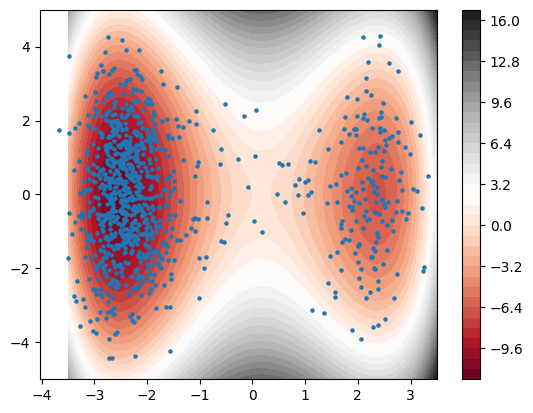

Epoch 301, loss: -2.0972196844356215
Epoch 302, loss: -2.1484428913469387
Epoch 303, loss: -2.178152286524081
Epoch 304, loss: -2.224624635130603
Epoch 305, loss: -2.2635330183328644
Epoch 306, loss: -2.2755218715104544
Epoch 307, loss: -2.2670464535418535
Epoch 308, loss: -2.2241321477199523
Epoch 309, loss: -2.276978284812208
Epoch 310, loss: -2.2820234971900804
Epoch 311, loss: -2.3315798950872924
Epoch 312, loss: -2.346280033983606
Epoch 313, loss: -2.394797223909026
Epoch 314, loss: -2.422440548064848
Epoch 315, loss: -2.409135964556628
Epoch 316, loss: -2.406370841101321
Epoch 317, loss: -2.3971922927106846
Epoch 318, loss: -2.449260441229193
Epoch 319, loss: -2.4865968385577135
Epoch 320, loss: -2.4787397454124185
Epoch 321, loss: -2.5054210280283082
Epoch 322, loss: -2.5024498361568908
Epoch 323, loss: -2.4295172157366762
Epoch 324, loss: -2.4656578291351434
Epoch 325, loss: -2.5179732026350625
Epoch 326, loss: -2.5517827567482954
Epoch 327, loss: -2.5998014275930186
Epoch 328,

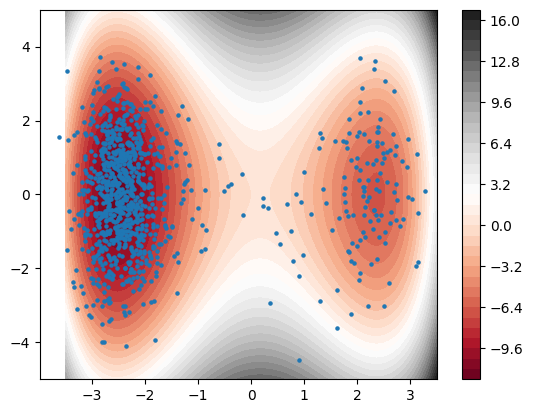

Epoch 351, loss: -2.757786677417686
Epoch 352, loss: -2.8190451653593667
Epoch 353, loss: -2.7867290513935106
Epoch 354, loss: -2.8550689236328846
Epoch 355, loss: -2.923666355685684
Epoch 356, loss: -2.9683857610373305
Epoch 357, loss: -3.0164376598082705
Epoch 358, loss: -3.07864883356219
Epoch 359, loss: -3.131461700862338
Epoch 360, loss: -3.1365260125704526
Epoch 361, loss: -3.1740245333184416
Epoch 362, loss: -3.1853522454092698
Epoch 363, loss: -3.23235010103075
Epoch 364, loss: -3.280828010575201
Epoch 365, loss: -3.284461193863618
Epoch 366, loss: -3.3348763776845387
Epoch 367, loss: -3.3244212879198445
Epoch 368, loss: -3.3583302813031795
Epoch 369, loss: -3.4028311301896723
Epoch 370, loss: -3.404752087591736
Epoch 371, loss: -3.441769820171464
Epoch 372, loss: -3.47813825089486
Epoch 373, loss: -3.3600877584897892
Epoch 374, loss: -3.397632567871769
Epoch 375, loss: -3.433636252522229
Epoch 376, loss: -3.4153345666732595
Epoch 377, loss: -3.4428742941153887
Epoch 378, loss:

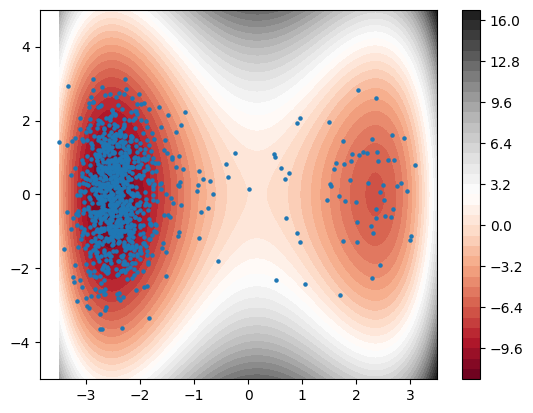

Epoch 401, loss: -3.944456791574811
Epoch 402, loss: -4.0160790111955125
Epoch 403, loss: -4.080008237231205
Epoch 404, loss: -4.106301881175891
Epoch 405, loss: -4.168014607750072
Epoch 406, loss: -4.162040153932719
Epoch 407, loss: -4.1347244760245845
Epoch 408, loss: -4.191402003683235
Epoch 409, loss: -4.094065049550051
Epoch 410, loss: -4.168655613055362
Epoch 411, loss: -4.172701023278897
Epoch 412, loss: -4.243185827160668
Epoch 413, loss: -4.304388705244112
Epoch 414, loss: -4.32670224021153
Epoch 415, loss: -4.322497447245968
Epoch 416, loss: -4.369879871046022
Epoch 417, loss: -4.308226979853912
Epoch 418, loss: -4.387110719077977
Epoch 419, loss: -4.419415906008773
Epoch 420, loss: -4.3416420605405195
Epoch 421, loss: -4.3637747809687815
Epoch 422, loss: -4.443217195399047
Epoch 423, loss: -4.4663164789640195
Epoch 424, loss: -4.542478530557103
Epoch 425, loss: -4.542247680742502
Epoch 426, loss: -4.576663715111935
Epoch 427, loss: -4.605601374864676
Epoch 428, loss: -4.6527

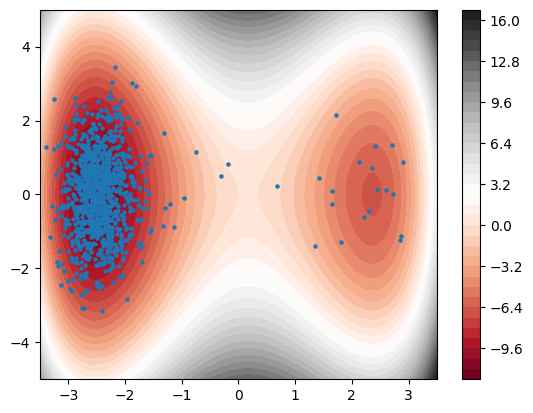

Epoch 451, loss: -5.334296879723323
Epoch 452, loss: -5.412888729803343
Epoch 453, loss: -5.338990646369241
Epoch 454, loss: -5.3037090155769695
Epoch 455, loss: -5.398161627161302
Epoch 456, loss: -5.481824420080298
Epoch 457, loss: -5.469908558461722
Epoch 458, loss: -5.504726767632785
Epoch 459, loss: -5.5527768881460515
Epoch 460, loss: -5.630869493787155
Epoch 461, loss: -5.690877175098242
Epoch 462, loss: -5.712100121320005
Epoch 463, loss: -5.725538245590307
Epoch 464, loss: -5.753931582970803
Epoch 465, loss: -5.814834268702802
Epoch 466, loss: -5.8012807675400895
Epoch 467, loss: -5.765481039912572
Epoch 468, loss: -5.825922308740183
Epoch 469, loss: -5.873442067589483
Epoch 470, loss: -5.916849556875176
Epoch 471, loss: -5.981935503267666
Epoch 472, loss: -6.018689195711661
Epoch 473, loss: -6.090422367209365
Epoch 474, loss: -6.1468456397890225
Epoch 475, loss: -6.213192874665694
Epoch 476, loss: -6.265788997646397
Epoch 477, loss: -6.257554283075772
Epoch 478, loss: -6.2946

In [44]:
from copy import deepcopy

rng_key = jax.random.PRNGKey(41)
initial_sigma = 0.1
#training_data = jax.random.normal(rng_key, shape=(10, batch_size, 2))*initial_sigma

params = reverse_model.init(rng_key, batch=jnp.ones([batch_size, 2]))
# optimizer = optax.adam(learning_rate=1e-2)
# params = fit(params, optimizer, 10, training_data)

# random_data = jax.random.normal(rng_key, (2, batch_size, 2*n_channels))
training_data_copy = jnp.array(training_data)
optimizer = optax.adam(learning_rate=1e-3)
params, training_data_copy = adaptive_fit(params, optimizer, 500, training_data_copy,
                                 rng_key=rng_key, efun=f, sigma_range=[0.5, 1], log_beta_range=[-1, 0])
# params, training_data_copy = adaptive_fit(params, optimizer, 100, training_data_copy,
#                                  rng_key=rng_key, efun=f, sigma_range=[1, 1], log_beta_range=[0, 0])

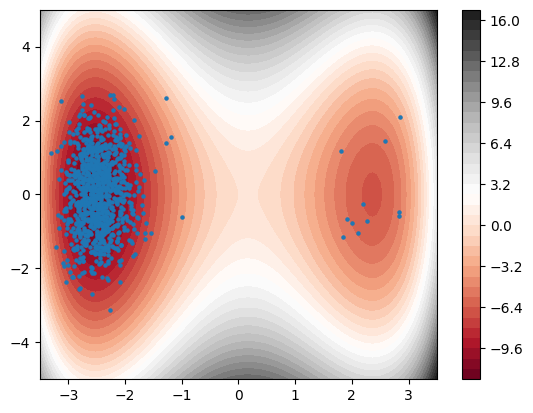

In [42]:
plot_latent_space(forward_model, params, sigma=1)

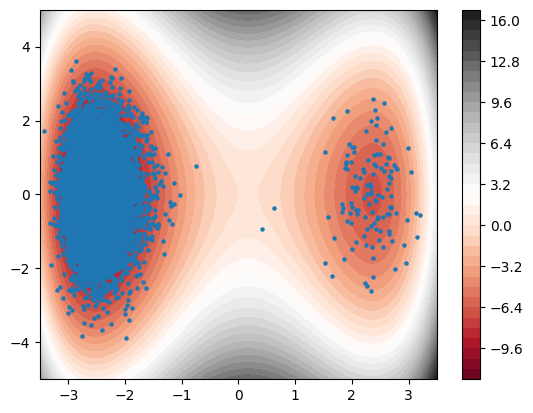

In [38]:
plt.contourf(X, Y, E, 40, cmap='RdGy') 
plt.colorbar();
plt.scatter(training_data_copy[:,:,0], training_data_copy[:,:,1], s=5)

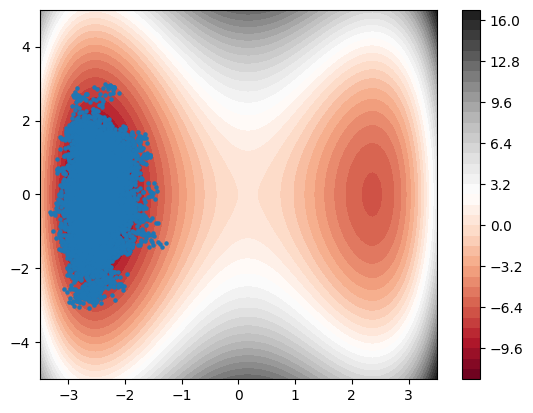

In [39]:
plt.contourf(X, Y, E, 40, cmap='RdGy') 
plt.colorbar();
plt.scatter(training_data[:,:,0], training_data[:,:,1], s=5)